In [ ]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [ ]:
class BottleNeck(nn.Module):
    expansion_factor=4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [ ]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block,128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block,256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block,512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._init_layer()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1) # [stride, 1, 1, ..., 1] 1은 num_block -1 개
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
class Model:
    def resnet18(self):
        return Resnet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return Resnet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return Resnet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return Resnet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return Resnet(BottleNeck, [3, 8, 36, 3])

Conv2 Features Shape: torch.Size([1, 256, 56, 56])


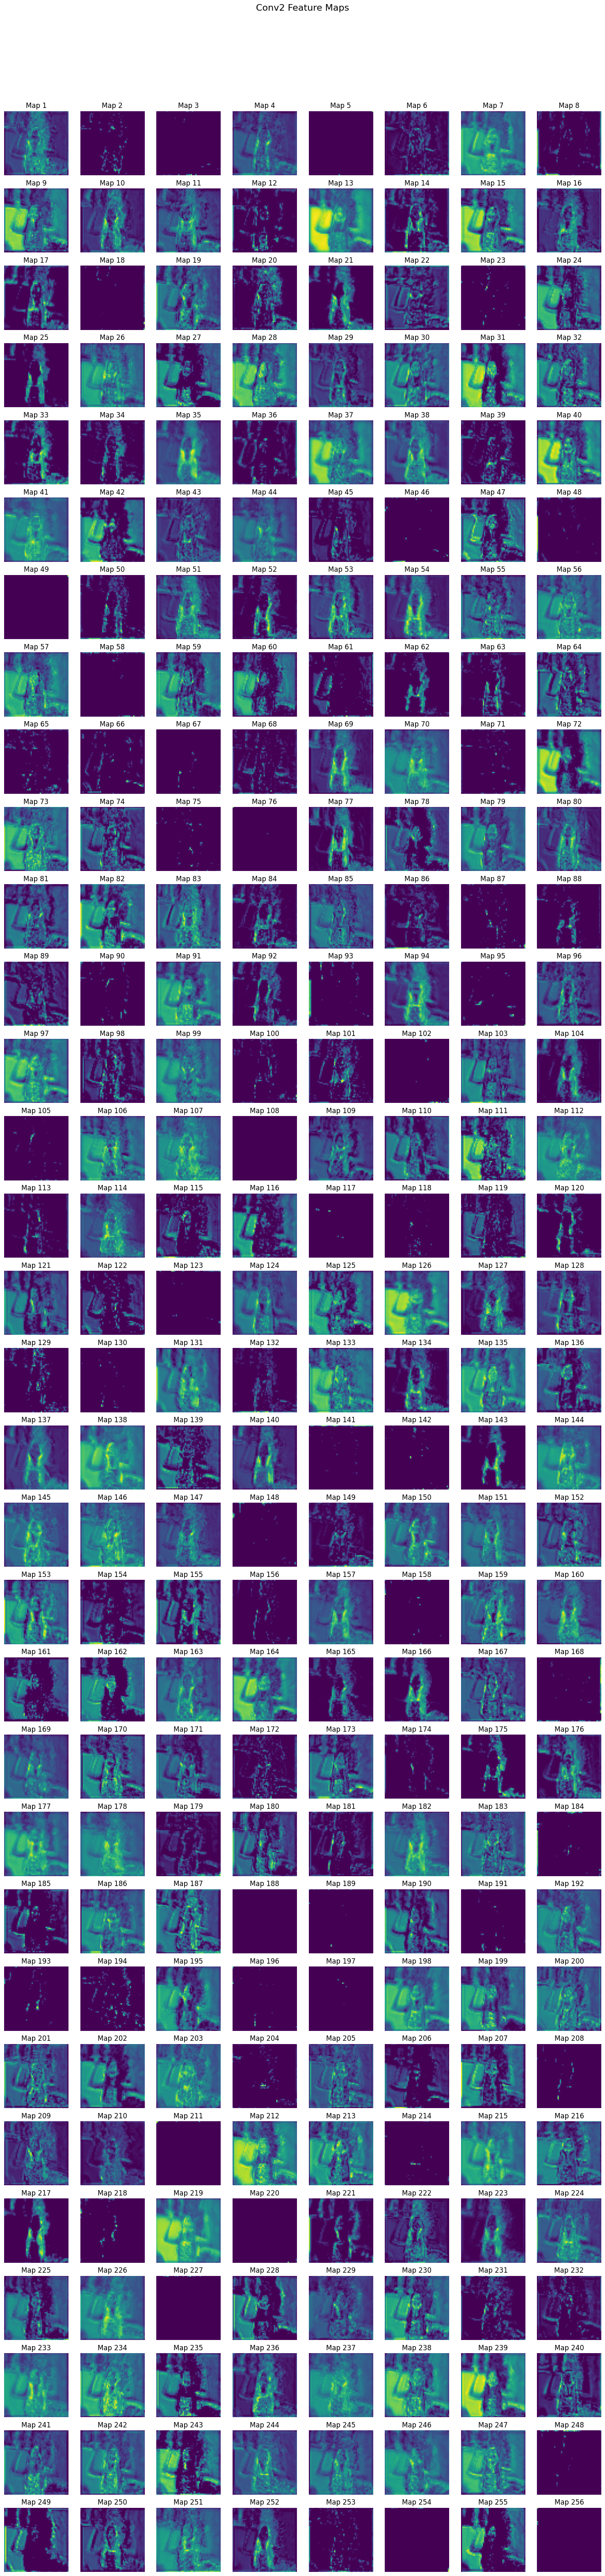

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# 시각화 함수 정의
def visualize_feature_maps(feature_maps, title):
    num_maps = feature_maps.shape[1]
    cols = 8
    rows = (num_maps + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < num_maps:
            axes[i].imshow(feature_maps[0, i].detach().cpu(), cmap="viridis")
            axes[i].axis("off")
            axes[i].set_title(f"Map {i + 1}")
        else:
            axes[i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 테스트 실행
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 모델 초기화
    model_creator = Model()
    model = model_creator.resnet50()
    model = model.to(device)

    model.eval()

    # 입력 이미지 로드 및 전처리
    image_path = "/content/60d5d255ba1c666e78fc39a65758f2e0_t.jpeg"  # 사용할 이미지 경로
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Feature Map 추출 및 시각화
    with torch.no_grad():
        x = model.conv1(input_tensor)  # 초기 Conv와 MaxPooling 통과
        conv2_features = model.conv2(x)  # 첫 번째 group (conv2) 통과

    print(f"Conv2 Features Shape: {conv2_features.shape}")
    visualize_feature_maps(conv2_features, "Conv2 Feature Maps")